In [44]:
# Import libraries
import pandas as pd
import pandas_ta as ta
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [45]:
timeframe = "H1"
symbols = ["GBP_JPY"]
systems = ["Strat"]
starting_balance = 100
risk_per_trade = 0.02 # Risking 2% per trade
market_open_time = "09:00"
opening_range_hours = 5
latest_entry_time = "22:00"
trade_direction = "long"
timezone = "Europe/London"

In [46]:
# Load CSV File
def get_price_data(symbol):
    df = pd.read_csv(f"../data/{symbol}_{timeframe}.csv", parse_dates=['Datetime'], index_col='Datetime')
    df.index = pd.to_datetime(df.index, utc=True).tz_convert(timezone)  # Keeps local timezone without converting to UTC
    return df

In [47]:
def calculate_inputs(df):
  
    # Ensure the Datetime column is a datetime object
    df.index = pd.to_datetime(df.index)
    df['Date'] = df.index.date
    df['Time'] = df.index.time
    df['Last_Candle'] = df['Date'] != df['Date'].shift(-1)

    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)

    # Calculate the opening range end time
    opening_range_start_time = (pd.Timestamp.combine(pd.Timestamp.today(), pd.to_datetime(market_open_time, format="%H:%M").time()) 
                            - pd.Timedelta(hours=opening_range_hours)).time()

    # Filter the DataFrame for the opening range period
    df_open_range = df[
        (df['Time'] >= opening_range_start_time) & 
        (df['Time'] < pd.to_datetime(market_open_time, format="%H:%M").time())
    ]

    # Group by each trading day and calculate the high and low for that range
    opening_range = df_open_range.groupby('Date').agg(
        Open_Range_High=('High', 'max'),
        Open_Range_Low=('Low', 'min')
    )

    # Merge the opening range back to the original DataFrame without resetting the index
    df = df.join(opening_range, on='Date')

    # Drop the 'Time' and 'Date' columns if no longer needed
    df = df.drop(['Time', 'Date'], axis=1)

    return df

In [48]:
def generate_signals(df, s, atr_sl, tp_ratio):
    # Get hour values
    df["Hour"] = df.index.hour
    
    # Various entry conditions
    c1_long = (df['Open'] <= df['Open_Range_High']) & (df['Close'] > df['Open_Range_High'])  # Breakout above opening range (long signal)
    c1_short = (df['Open'] >= df['Open_Range_Low']) & (df['Close'] < df['Open_Range_Low'])  # Breakout below opening range (short signal)
    
    c2 = df.index.time >= pd.to_datetime(market_open_time, format='%H:%M').time()
    c3 = df.index.time <= pd.to_datetime(latest_entry_time, format='%H:%M').time()
    c4 = df['Open_Range_High'].notna() # Check that the current candle actually has a range. The sunday candles on CFDs can open in the evening
    c5 = (df['High'] - df['Low']) < df['ATR'] * 2.5
    c6 = (df['High'] - df['Low']) > df['ATR'] * 1.0

    #generate entries and exits
    # Entries depend on the strategy
    if s == "Strat":
        if trade_direction == "long":
            # default entry rules
            df[f"{s}_Signal"] = c1_long.shift(1) & c2 & c3 & c4 & c5.shift(1) & c6.shift(1)
        elif trade_direction == "short":
            df[f"{s}_Signal"] = c1_short.shift(1) & c2 & c3 & c4 & c5.shift(1) & c6.shift(1)

    # Generate exits
    if trade_direction == "long":
        nominal_stop_dist = df['Open'] - df['Open_Range_Low']
        df['SL'] = df['Open'] - nominal_stop_dist * atr_sl
        stop_dist = df['Open'] - df['SL']
        df['TP'] = df['Open'] + stop_dist * tp_ratio
    elif trade_direction == "short":
        nominal_stop_dist = df['Open_Range_High'] - df['Open']
        df['SL'] = df['Open'] + nominal_stop_dist * atr_sl
        stop_dist = df['SL'] - df['Open']
        df['TP'] = df['Open'] - stop_dist * tp_ratio
   
    return df

In [49]:
def generate_trades(df, s):
    #create empty list for trades
    trades_list = []
    trade_open = False
    open_change = {}
    balance = starting_balance
    equity = starting_balance
    balance_history = []
    equity_history = []
    
    #iterate through rows to work out entries and exits
    for i, row in df.iterrows():
        #if there is currently no trade
        if not trade_open:
            #check if long signal was generated and enter at the same time
            if row[f"{s}_Signal"] == True:
                entry_date = i
                entry_price = row.Open
                sl = row.SL
                tp = row.TP
                # Calculate position size based on risk percentage
                risk_amount = balance * risk_per_trade
                if entry_price == sl:
                    position_size = 0.01
                else:
                    position_size = risk_amount / abs(entry_price - sl)  # Position size in units
                trade_open = True
        #check if a trade is already open
        if trade_open:
            #get price values
            low = row.Low
            high = row.High

            if trade_direction == "long":
                # Calculate unrealized PnL
                floating_pnl = (high - entry_price) * position_size
                equity = balance + floating_pnl  # Update equity dynamically

                # Calculate unrealized PnL
                #check if stop is hit
                if low <= sl:
                    #first check for a gap down
                    if row.Open <= sl:
                        exit_price = row.Open
                    else:
                        exit_price = sl
                    trade_open = False

                # Now do the same check for take profit
                elif high >= tp:
                    #first check for a gap up
                    if row.Open >= tp:
                        exit_price = row.Open
                    else:
                        exit_price = tp
                    trade_open = False

            elif trade_direction == "short":
                floating_pnl = (entry_price - low) * position_size
                equity = balance + floating_pnl  # Update equity dynamically

                # Calculate unrealized PnL
                #check if stop is hit
                if high >= sl:
                    #first check for a gap down
                    if row.Open >= sl:
                        exit_price = row.Open
                    else:
                        exit_price = sl
                    trade_open = False

                # Now do the same check for take profit
                elif low <= tp:
                    #first check for a gap up
                    if row.Open <= tp:
                        exit_price = row.Open
                    else:
                        exit_price = tp
                    trade_open = False

            if not trade_open: # If trade has been closed
                exit_date = i
                trade_open = False

                if trade_direction == "long":   
                    pnl = (exit_price - entry_price) * position_size  # PnL in currency terms
                elif trade_direction == "short":
                    pnl = -1 * (exit_price - entry_price) * position_size # PnL in currency terms
                balance += pnl  # Update balance with PnL
                

                #store trade data in a list
                trade = [entry_date, entry_price, exit_date, exit_price, position_size, pnl, balance, True]
                #append trade to overall trade list
                trades_list.append(trade)

        # Store balance and equity
        balance_history.append(balance)
        equity_history.append(equity)

    trades = pd.DataFrame(trades_list, columns=["Entry_Date", "Entry_Price", "Exit_Date", "Exit_Price", "Position_Size", "PnL", "Balance", "Sys_Trade"])
    
    #calculate return of each trade as well as the trade duration
    trades[f"{s}_Return"] = trades.Balance / trades.Balance.shift(1)
    dur = []
    for i, row in trades.iterrows():
        d1 = row.Entry_Date
        d2 = row.Exit_Date
        dur.append(np.busday_count(d1.date(), d2.date()) + 1)#Add 1 because formula doesn't include the end date otherwise
    
    trades[f"{s}_Duration"] = dur

    #create a new dataframe with an index of exit dfs
    returns = pd.DataFrame(index=trades.Exit_Date)
    #create a new dataframe with an index of entries to track entry price
    entries = pd.DataFrame(index=trades.Entry_Date)

    entries[f"{s}_Entry_Price"] = pd.Series(trades.Entry_Price).values
    #add the Return column to this new data frame
    returns[f"{s}_Ret"] = pd.Series(trades[f"{s}_Return"]).values
    returns[f"{s}_Trade"] = pd.Series(trades.Sys_Trade).values
    returns[f"{s}_Duration"] = pd.Series(trades[f"{s}_Duration"]).values
    returns[f"{s}_PnL"] = pd.Series(trades.PnL).values
    returns[f"{s}_Balance"] = pd.Series(trades.Balance).values
    change_ser = pd.Series(open_change, name=f"{s}_Change")

    #add the returns from the trades to the main data frame
    df = pd.concat([df, returns, entries, change_ser], axis=1)
    #fill all the NaN return values with 1 as there was no profit or loss on those days
    df[f"{s}_Ret"] = df[f"{s}_Ret"].fillna(1)
    #fill all the NaN trade values with False as there was no trade on those days
    df[f"{s}_Trade"] = df[f"{s}_Trade"].infer_objects(copy=False)
    #fill all the NaN return values with 1 as there was no loss on those days
    df[f"{s}_Change"] = df[f"{s}_Change"].astype(float).fillna(1)
    
    #use the updated balance and equity variables
    df[f"{s}_Bal"] = pd.Series(balance_history, index=df.index).ffill()
    df[f"{s}_Equity"] = pd.Series(equity_history, index=df.index).ffill()

    active_trades = np.where(df[f"{s}_Trade"] == True, True, False)
    df[f"{s}_In_Market"] = df[f"{s}_Trade"].copy()
    #populate trades column based on duration
    for count, t in enumerate(active_trades):
        if t == True:
            dur = df[f"{s}_Duration"].iat[count]
            for i in range(int(dur)):
                #starting from the exit date, move backwards and mark each trading day
                df[f"{s}_In_Market"].iat[count - i] = True
    
    return df, trades

In [50]:
def backtest(price, atr_sl, tp_ratio):
    #calculate strategy inputs
    price = calculate_inputs(price)

    for s in systems:
        #generate signals
        price = generate_signals(price, s, atr_sl, tp_ratio)

        #generate trades
        price, trades = generate_trades(price, s)

    for s in systems:
        #calculate drawdown
        price[f"{s}_Peak"] = price[f"{s}_Bal"].cummax()
        price[f"{s}_DD"] = price[f"{s}_Bal"] - price[f"{s}_Peak"]

    return price, trades

In [51]:
results = []
prog = 0
sl_range = np.arange(1.0, 1.5, 0.5)
tp_range = np.arange(1.5, 2.0, 0.5)
max_prog = len(symbols) * len(sl_range) * len(tp_range)
for sym in symbols:
    price = get_price_data(sym)
    for atr_sl in sl_range:
        for tp_ratio in tp_range:
            result, trades = backtest(price, atr_sl, tp_ratio)
            results.append(result)
            prog += 1
            clear_output(wait=True)
            print(f"Progress: {round((prog / max_prog) * 100)} %")

Progress: 100 %


In [52]:
def get_metrics(system, data):
    rfr = 0.03 # risk free return rate of 3%
    if timeframe == "daily":
        N = 252 # number of trading days per year
    elif timeframe == "H1":
        N = 252 * 6.5 # number of trading hours per year
    elif timeframe == "M15":
        N = 252 * 6.5 * 4
    elif timeframe == "M5":
        N = 252 * 6.5 * 12
    metrics = {}
    years = (data.index[-1] - data.index[0]).days / 365.25
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_peak = data[f"{system}_Bal"].cummax()
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    rod = sys_cagr / abs(sys_dd)
    periods_in_market = data[f"{system}_In_Market"].sum()
 
    win = data[f"{system}_Ret"] > 1
    loss = data[f"{system}_Ret"] < 1
    signals = data[f"{system}_Signal"].sum()
    trades_triggered = data[f"{system}_Trade"].sum()
    tim = round(periods_in_market / len(data) * 100, 2)
    rbe = round((sys_cagr / tim) * 100, 2)
    rbeod = rbe / abs(sys_dd) # return by exposure by drawdown (assuming drawdown doesn"t scale as TIM increases. Could be wrong)
    gaps = (data.Open > data[f"{system}_Entry_Price"]).sum()
    non_gaps = (data.Open <= data[f"{system}_Entry_Price"]).sum()
    wins = win.sum()
    losses = loss.sum()
    winrate = round(wins / (wins + losses) * 100, 2)
    
    # calculate the size of the move from the entry data to the close
    ret_size = np.where(data[f"{system}_Trade"] == True, data[f"{system}_Ret"], 1)
    avg_up_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] > 1].mean() - 1) * 100
    max_up_move = (data[f"{system}_Ret"].max() - 1) * 100
    avg_down_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] < 1].mean() - 1) * 100
    max_down_move = (data[f"{system}_Ret"].min() - 1) * 100
    avg_rr = round(abs(avg_up_move / avg_down_move), 2)

    #sharpe ratio
    ret = data[f"{system}_Bal"].pct_change().dropna()
    excess_ret = ret - rfr/N
    sharpe = np.sqrt(N) * excess_ret.mean() / excess_ret.std()

    #sortino ratio
    downside_std = excess_ret[excess_ret < 0].std()
    sortino = np.sqrt(N) * excess_ret.mean() / downside_std
        
    # Calculate longest trade and average trade duration
    longest_trade_duration = data["Strat_Duration"].max()
    avg_trade_duration = data["Strat_Duration"].mean()

    #save data
    metrics["Start_Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final_Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    #metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual_Return"] = round(sys_cagr, 2)
    #metrics["Time_in_Market"] = round(tim, 2)
    #metrics["Return_By_Exposure"] = rbe
    metrics["Max_Drawdown"] = round(sys_dd, 2)
    #metrics["Return_Over_Drawdown"] = round(rod, 2)
    #metrics["RBE_Over_Drawdown"] = round(rbeod, 2)
    metrics["Sharpe"] = round(sharpe, 2)
    metrics["Sortino"] = round(sortino, 2)
    #metrics["Signals"] = round(signals, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    #metrics["Gap"] = round(gaps)
    #metrics["No_Gap"] = round(non_gaps)
    #metrics["Wins"] = round(wins, 2)
    #metrics["Losses"] = round(losses, 2)
    metrics["Winrate"] = round(winrate, 2)
    #metrics["Max_Trade_Return_pct"] = round(max_up_move, 2)
    #metrics["Max_Trade_Loss_pct"] = round(max_down_move, 2)
    #metrics["Avg_Trade_Return_pct"] = round(avg_up_move, 2)
    #metrics["Avg_Trade_Loss_pct"] = round(avg_down_move, 2)
    metrics["Avg_RR"] = avg_rr

    # Add Longest and Average Trade Duration
    metrics["Longest_Trade_Duration"] = longest_trade_duration
    metrics["Avg_Trade_Duration"] = round(avg_trade_duration, 2)

    return metrics

In [53]:
for count, res in enumerate(results):
    sys_metrics = {}
    for s in systems:
        sys_metrics.update({s: get_metrics(s, res)})
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)

In [54]:
def show_trades(df, trades, start_date=None, end_date=None, trade_number=None):

    # Ensure datetime index with timezone awareness
    df.index = pd.to_datetime(df.index).tz_convert(timezone)
    trades['Entry_Date'] = pd.to_datetime(trades['Entry_Date']).dt.tz_convert(timezone)
    trades['Exit_Date'] = pd.to_datetime(trades['Exit_Date']).dt.tz_convert(timezone)

    # If start_date is provided, filter the trades dataframe to only include trades after the start_date
    if start_date:
        start_date = pd.Timestamp(start_date, tz=timezone)
        trades = trades[trades['Entry_Date'] >= start_date]
        trades = trades[trades['Exit_Date'] >= start_date]  # Ensure exit date is also after the start_date
    
    # If trade_number is specified, filter the data based on that trade's entry and exit dates
    if trade_number is not None:
        # Get the specific trade's entry and exit dates using iloc to avoid KeyError after filtering
        trade_entry_date = trades.iloc[trade_number]['Entry_Date']
        trade_exit_date = trades.iloc[trade_number]['Exit_Date']
        
        # Extend the date range by 1 day before entry and 1 day after exit
        extended_start_date = trade_entry_date - pd.Timedelta(days=1)
        extended_end_date = trade_exit_date + pd.Timedelta(days=1)

        # Filter the price data (df) and trades data by the extended entry and exit dates
        df = df[(df.index >= extended_start_date) & (df.index <= extended_end_date)]
        trades = trades[(trades['Entry_Date'] >= extended_start_date) & (trades['Exit_Date'] <= extended_end_date)]
    else:
        # If no trade_number is passed, apply the global date range filters
        if start_date:
            df = df[df.index >= start_date]
            trades = trades[trades['Entry_Date'] >= start_date]
        if end_date:
            end_date = pd.Timestamp(end_date, tz=timezone)
            df = df[df.index <= end_date]
            trades = trades[trades['Exit_Date'] <= end_date]

    # Create buy and sell signals from trades dataframe
    buy_signals = pd.DataFrame({
        'date': trades['Entry_Date'],
        'price': trades['Entry_Price']
    }).set_index('date')

    sell_signals = pd.DataFrame({
        'date': trades['Exit_Date'],
        'price': trades['Exit_Price']
    }).set_index('date')
    
    # Create the figure
    fig = go.Figure()

    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name='Candlestick',
        increasing_line_color='green',
        decreasing_line_color='red'
    ))

    # Plot buy and sell signals
    fig.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals['price'], 
                             mode='markers+text', marker=dict(symbol='diamond', color='green', size=12, line=dict(color='black', width=2)), 
                             name='Buy Signal', text='BUY', textposition='bottom center', 
                             textfont=dict(size=14, color='black', family='Arial', weight='bold')))
    fig.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals['price'], 
                             mode='markers+text', marker=dict(symbol='diamond', color='red', size=12, line=dict(color='black', width=2)),
                             name='Sell Signal', text='SELL', textposition='top center', 
                             textfont=dict(size=14, color='black', family='Arial', weight='bold')))

    # Customize layout for panning and zooming
    fig.update_layout(
        title='Candlestick Chart with Indicators and Trade Signals',
        xaxis_title='Datetime',
        yaxis_title='Price',
        xaxis_rangeslider_visible=True,  # Enable range slider
        height=900,
        autosize=True,  # Enable auto resize for the chart
        margin={'l': 50, 'r': 50, 't': 60, 'b': 60},  # Add margins around the chart
        showlegend=True,
        xaxis=dict(
            type='category',  # Treat the x-axis as categorical to remove gaps
            rangeslider=dict(visible=True),  # Rangeslider visible for easier panning
            fixedrange=False,  # Disable zooming with the mouse wheel, only panning allowed
        ),
        yaxis=dict(
            fixedrange=False,  # Allow zooming on y-axis too
        ),
    )

    fig.show()

In [55]:
show_trades(price, trades, start_date="2024, 1, 1", trade_number=1)

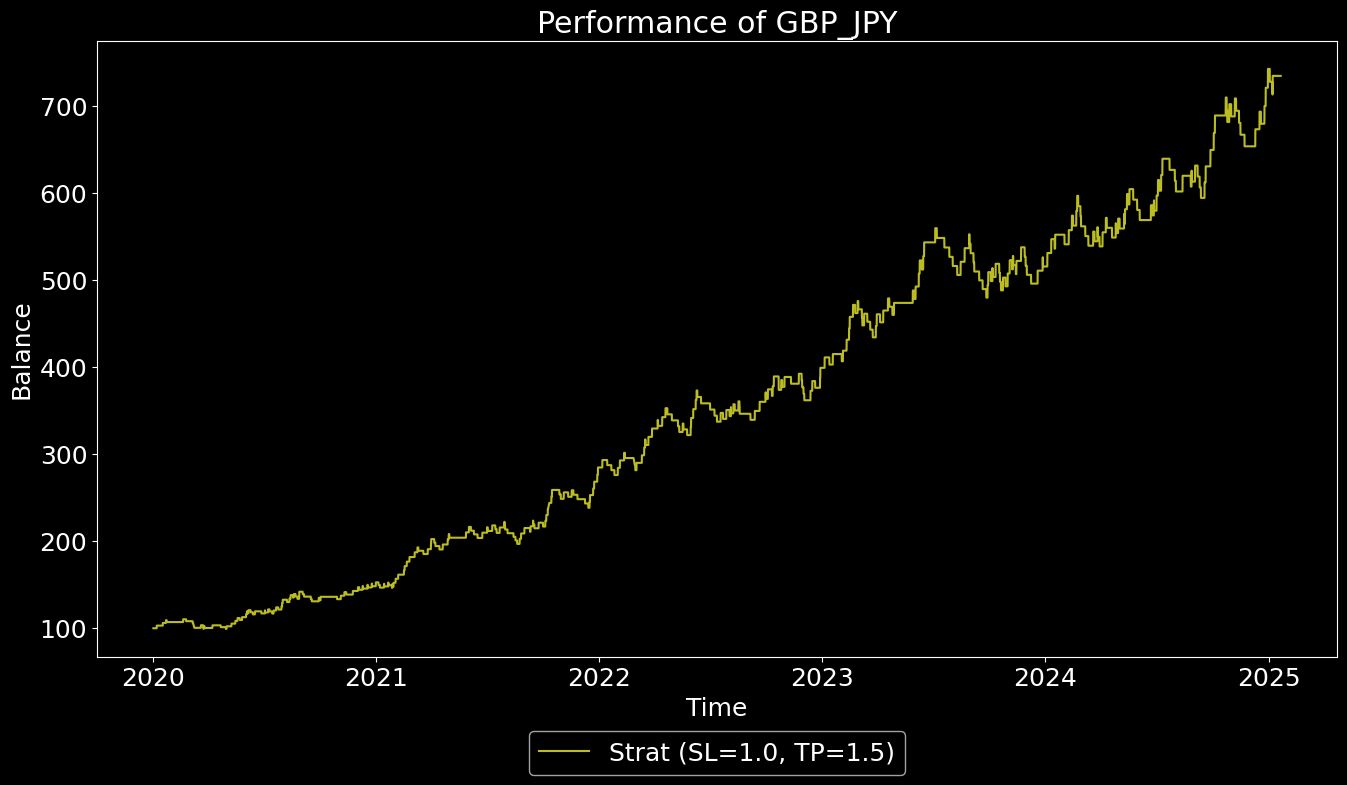

In [56]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({"font.size": 18})

colours = ["tab:olive", "tab:blue", "tab:purple", "tab:orange", "tab:green", "tab:cyan", "tab:red", "tab:gray", "tab:pink"]

for count, sym in enumerate(symbols):
    plt.figure()
    plt.title(f"Performance of {sym}")

    legend_entries = []  # Store legend labels
    colour_idx = 0  # To cycle through colors if needed

    for atr_sl in sl_range:
        for tp_ratio in tp_range:
            for c, s in enumerate(systems):
                # Generate a unique index for each (SL, TP) combination
                result_idx = count * len(sl_range) * len(tp_range) + list(sl_range).index(atr_sl) * len(tp_range) + list(tp_range).index(tp_ratio)

                if result_idx >= len(results):  
                    continue  # Prevent out-of-bounds error

                label = f"{s} (SL={atr_sl}, TP={tp_ratio})"  # Legend label
                color = colours[colour_idx % len(colours)]  # Cycle through colors
                
                plt.plot(results[result_idx][f"{s}_Bal"], color=color, label=label)
                legend_entries.append(label)

                colour_idx += 1  # Move to next color

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.xlabel("Time")
    plt.ylabel("Balance")
    #plt.grid(True, linestyle="--", alpha=0.5)
    plt.savefig("plot.png", format="png", dpi=300, bbox_inches="tight")
    plt.show()




In [57]:
print(sys_metrics_df)

                         Strat
Start_Balance           100.00
Final_Balance           735.12
Annual_Return            48.43
Max_Drawdown            -14.25
Sharpe                    0.70
Sortino                   1.27
Trades                  382.00
Winrate                  51.18
Avg_RR                    1.48
Longest_Trade_Duration   22.00
Avg_Trade_Duration        2.70


In [58]:
# Split index into 'Date' and 'Time' columns
trades['Entry_Date'] = pd.to_datetime(trades["Entry_Date"])
trades['Entry_Hour'] = trades['Entry_Date'].dt.hour

# Convert "Strat_Breakout_Return" to percentage
trades["Return_Percentage"] = (trades[f"{systems[-1]}_Return"] - 1) * 100

# Group by Hour and Calculate Average PnL
hourly_return = trades.groupby("Entry_Hour")["Return_Percentage"].mean()

# Group by Hour and Count Number of Trades
hourly_trades_count = trades.groupby("Entry_Hour")["Return_Percentage"].count()

# Combine the two results into a single DataFrame
hourly_stats = pd.DataFrame({
    "Average_Return_Percentage": hourly_return,
    "Trades_Count": hourly_trades_count
})

# Display Result
print(hourly_stats)

            Average_Return_Percentage  Trades_Count
Entry_Hour                                         
10                           0.622951           122
11                           0.672414            58
12                           0.343750            32
13                           0.277135            26
14                           0.500000            30
15                           0.125000            40
16                           1.055556            36
17                           0.352941            17
18                           1.571429             7
19                           0.500000             2
20                          -2.000000             4
21                           0.367241             5
22                           3.000000             2


In [59]:
result.index = pd.to_datetime(result.index)

# Extract unique years
years = result.index.year.unique()

# Calculate returns
data = []
for year in result.index.year.unique():
    yearly_data = result[result.index.year == year]
    
    for system in systems:
        start_bal = yearly_data[f"{system}_Bal"].iloc[0]
        end_bal = yearly_data[f"{system}_Bal"].iloc[-1]
        return_pct = ((end_bal - start_bal) / start_bal) * 100
        data.append([year, system, return_pct])

# Convert to DataFrame
returns_df = pd.DataFrame(data, columns=["Year", "System", "Return"])


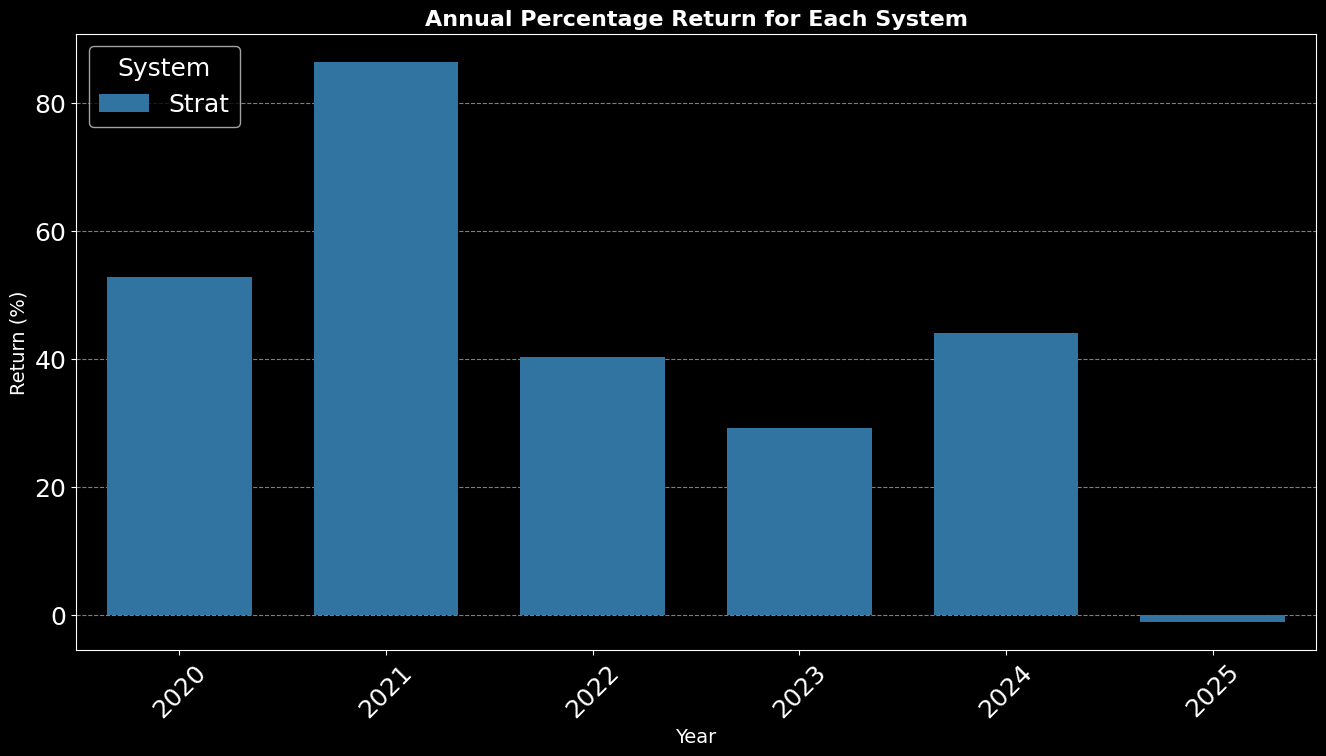

In [60]:
# Set up the figure
plt.figure(figsize=(16, 8))
sns.set_palette("tab10")

# Plot the bar chart
ax = sns.barplot(data=returns_df, x="Year", y="Return", hue="System", dodge=True, width=0.7)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add title and labels
plt.ylabel("Return (%)", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.title("Annual Percentage Return for Each System", fontsize=16, fontweight='bold')

# Gridlines
ax.set_axisbelow(True)
plt.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)

# Legend
plt.legend(title="System", loc="upper left")

# Show the final chart
plt.show()

In [61]:
trades.to_csv("trades.csv")
result.to_csv("result.csv")